In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import configparser
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

plt.rcParams['font.size'] = 13

In [2]:
def extract_data():
  # Load data sets
  datasets_folder = "/content/drive/My Drive/Colab Notebooks/WaterDatasets/Initial/"

  cfg_path = os.path.join(datasets_folder, "params.cfg")
  file_path = os.path.join(datasets_folder, "geojson_1.csv")
  config = configparser.ConfigParser()

  # Check if the files exists
  if not os.path.exists(file_path):
      print(f"Error: Data file not found at '{file_path}'")
      return

  if not os.path.exists(cfg_path):
      print(f"Error: Configuration file not found at '{cfg_path}'")
      return

  try:
      config.read(cfg_path)
      print(f"Successfully read configuration from '{file_path}'\n")

      primary_basin = config.get('ETL_params', 'primary_basin')
      station_name = config.get('ETL_params', 'station_name')
      indicator = config.get('ETL_params', 'indicator')
      predict_range = config.get('ETL_params', 'predict_range')

      print(f"Primary basin: {primary_basin}")
      print(f"Station name: {station_name}")
      print(f"Indicator: {indicator}")
      print(f"Predict range: {predict_range}")
  except configparser.Error as e:
      print(f"Error parsing configuration file: {e}")
  except Exception as e:
      print(f"An unexpected error occurred: {e}")

  full_data = pd.read_csv(file_path)
  river = full_data.loc[full_data['primary_basin'] == 'Quoile']
  river = river.loc[river['station_name'] == 'QUOILE RIVER AT QUOILE BRIDGE']

  # display total number of rows and cols
  print(f"\n{primary_basin} river ->" + f" Rows: {river.shape[0]}, Cols: {river.shape[1]}")

  print("\nData load was successfull")
  return (river, indicator, primary_basin, predict_range)

In [3]:
def transform_data(river, indicator):
  # assert that there are no missing values
  assert [river.notnull().all().all()]

  # assert that data set contains no duplicated records
  assert [river.duplicated().sum() == 0]

  # change date values from string to datetime object
  river['date'] = pd.to_datetime(river['date'], format='%Y-%m-%dT%H:%M:%SZ')

  river.reset_index(drop=True)
  river.set_index('date', inplace = True)

  indicator_river_data = river[[f'{indicator}']]
  indicator_river_data = indicator_river_data.dropna()

  print("\nData transaformation was successfull")
  return indicator_river_data

In [4]:
def generate_dashboard(indicator_river_data, indicator, indicator_river_folder_path):
    decomposed_indicator = sm.tsa.seasonal_decompose(indicator_river_data, period=len(indicator_river_data)//2, model='additive')

    plt.subplots_adjust(wspace=0, hspace=1)
    fig = plt.figure(figsize=(25, 20))
    gs = fig.add_gridspec(nrows=4, ncols=3, height_ratios=[1, 1, 1, 1], width_ratios=[1, 0.7, 0.7])

    fig.suptitle(f'Time Series Analysis Dashboard: {indicator} Data', fontsize=18, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[1, 1, 1, 1]) # [left, bottom, right, top] margins

    ax_observed = fig.add_subplot(gs[0, 0]) # First row, first column
    decomposed_indicator.observed.plot(ax=ax_observed, color='black', label=f'{indicator}')
    ax_observed.set_title(f'Observed {indicator}', fontsize=14)
    ax_observed.set_ylabel(f'{indicator}', fontsize=12)
    ax_observed.set_xlabel('')
    ax_observed.grid(True)
    ax_observed.set_facecolor('#f9f9f9')

    ax_trend = fig.add_subplot(gs[1, 0], sharex=ax_observed)
    decomposed_indicator.trend.plot(ax=ax_trend, color='black', label='Trend')
    ax_trend.set_title('Trend Component', fontsize=14)
    ax_trend.set_ylabel('Trend', fontsize=12)
    ax_trend.set_xlabel('')
    ax_trend.grid(True)
    ax_trend.set_facecolor('#f9f9f9')

    ax_seasonal = fig.add_subplot(gs[2, 0], sharex=ax_observed)
    decomposed_indicator.seasonal.plot(ax=ax_seasonal, color='black', label='Seasonal')
    ax_seasonal.set_title('Seasonal Component', fontsize=14)
    ax_seasonal.set_ylabel('Seasonal', fontsize=12)
    ax_seasonal.set_xlabel('')
    ax_seasonal.grid(True)
    ax_seasonal.set_facecolor('#f9f9f9')

    ax_residuals = fig.add_subplot(gs[3, 0], sharex=ax_observed)
    decomposed_indicator.resid.plot(ax=ax_residuals, color='black', label='Residuals')
    ax_residuals.set_title('Residuals Component', fontsize=14)
    ax_residuals.set_ylabel('Residuals', fontsize=12)
    ax_residuals.set_xlabel('Date', fontsize=12)
    ax_residuals.grid(True)
    ax_residuals.set_facecolor('#f9f9f9')

    ax_hist = fig.add_subplot(gs[2:4, 1:2]) # Spans rows 0 and 1, column 1 (of the right two columns)
    indicator_river_data.hist(ax=ax_hist, bins=25, color="black", edgecolor='black', alpha=0.8)
    ax_hist.set_xlabel(f"{indicator}", fontsize=12)
    ax_hist.set_ylabel("Frequency (quantity)", fontsize=12)
    ax_hist.set_title(f"Distribution of {indicator}", fontsize=14)
    ax_hist.set_facecolor('#f9f9f9')
    ax_hist.grid(axis='y', linestyle=':', alpha=0.7)

    descriptive_stats = indicator_river_data.describe()
    ax_stats = fig.add_subplot(gs[2:4, 2:3])
    descriptive_stats.loc[['mean', 'std']].T.plot(ax=ax_stats, kind='bar', yerr='std', capsize=4)
    ax_stats.set_title(f'Mean and Standard Deviation of {indicator}')
    ax_stats.set_ylabel('Value')
    ax_stats.grid(axis='y', linestyle='--', alpha=0.7)

    ax_acf = fig.add_subplot(gs[0, 1:3]) # Spans rows 0 and 1, column 2 (of the right two columns)
    sm.graphics.tsa.plot_acf(indicator_river_data.values, lags=100, ax=ax_acf, alpha=0.05)
    ax_acf.set_title('Autocorrelation Function (ACF)', fontsize=14)
    ax_acf.set_ylabel('Correlation', fontsize=12)
    ax_acf.set_xlabel('Lag', fontsize=12)
    ax_acf.grid(True)
    ax_acf.set_facecolor('#f9f9f9')

    if ax_acf.lines:
        ax_acf.lines[0].set_color('black')
        for line in ax_acf.lines[1:]:
            line.set_color('black')
            line.set_alpha(0.3)

    ax_pacf = fig.add_subplot(gs[1, 1:3]) # Spans rows 2 and 3, and columns 1 and 2 (of the right two columns)
    sm.graphics.tsa.plot_pacf(indicator_river_data.values, lags=100, ax=ax_pacf, alpha=0.05)
    ax_pacf.set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
    ax_pacf.set_ylabel('Correlation', fontsize=12)
    ax_pacf.set_xlabel('Lag', fontsize=12)
    ax_pacf.grid(True)
    ax_pacf.set_facecolor('#f9f9f9')

    if ax_pacf.lines:
        ax_pacf.lines[0].set_color('black')
        for line in ax_pacf.lines[1:]:
            line.set_color('black')
            line.set_alpha(0.3)

    output_filename_png = os.path.join(indicator_river_folder_path, f'{indicator}_time_series_dashboard.png')

    try:
        plt.savefig(output_filename_png, dpi=300, bbox_inches='tight')
        print(f"Dashboard saved successfully as {output_filename_png}")
        print()
        plt.close(fig)
    except Exception as e:
        print(f"Error saving PNG: {e}")

In [5]:
def arima_calculation(indicator_river_data, p, q, indicator_river_folder_path, predict_range, indicator):
  train_size = int(len(indicator_river_data) * 0.8)
  train, test = indicator_river_data.values[:train_size], indicator_river_data.values[train_size:]

  model = ARIMA(train, order=(1,p,q))
  model_fit = model.fit()
  print()
  print(model_fit.summary())

  summary = str(model_fit.summary())

  destination_path = os.path.join(indicator_river_folder_path, f"ARIMA{1,p,q}_{indicator}_summary.txt")

  with open(destination_path, "w") as file:
      file.write(summary)

  forecast = model_fit.forecast(steps=len(test))

  # Calculate errors
  mae = mean_absolute_error(test, forecast)
  mse = mean_squared_error(test, forecast)
  rmse = np.sqrt(mse)

  print(f"\nMAE: {mae:.4f}")
  print(f"MSE: {mse:.4f}")
  print(f"RMSE: {rmse:.4f}")

  tscv = TimeSeriesSplit(n_splits=5)
  errors = []

  for train_index, test_index in tscv.split(indicator_river_data.values):
      train, test = indicator_river_data.values[train_index], indicator_river_data.values[test_index]

      try:
          model = ARIMA(train, order=(1, p, q))
          model_fit = model.fit()
          predictions = model_fit.forecast(steps=len(test))
          rmse = np.sqrt(mean_squared_error(test, predictions))
          errors.append(rmse)
      except Exception as e:
          print(f"Error in split: {e}")
          continue

  print("\nRMSE per split:", [str(i) for i in errors])
  print("Average RMSE:", np.mean(errors))

  model_all_data = ARIMA(indicator_river_data.values, order=(1,p,q))
  model_fit = model_all_data.fit()
  forecast = model_fit.forecast(steps=int(predict_range))

  file_path = os.path.join(indicator_river_folder_path, f"ARIMA{1,p,q}_{indicator}_forecast.txt")
  forecast = pd.DataFrame({"Predicted_BOD": forecast})
  forecast.index.name = 'Measurement number'
  forecast.to_csv(file_path, index=True)

Successfully read configuration from '/content/drive/My Drive/Colab Notebooks/WaterDatasets/Initial/geojson_1.csv'

Primary basin: Quoile
Station name: QUOILE RIVER AT QUOILE BRIDGE
Indicator: bod_mgl
Predict range: 7

Quoile river -> Rows: 458, Cols: 27

Data load was successfull

Data transaformation was successfull

Folder '/content/drive/My Drive/Colab Notebooks/WaterDatasets/Results/Quoile_bod_mgl/' created successfully (or already exists).
Dashboard saved successfully as /content/drive/My Drive/Colab Notebooks/WaterDatasets/Results/Quoile_bod_mgl/bod_mgl_time_series_dashboard.png



<Figure size 640x480 with 0 Axes>

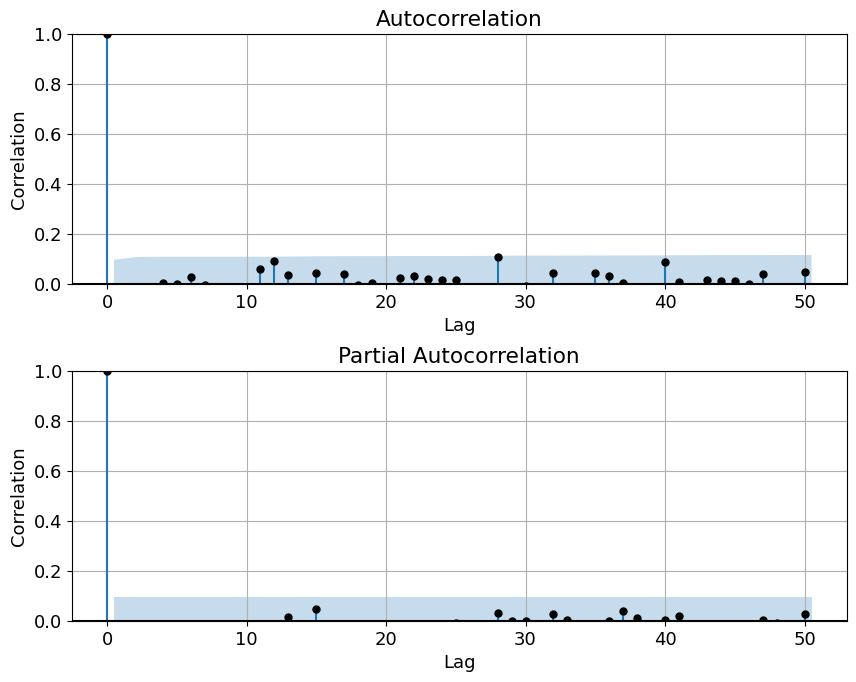


Please enter the number of lags that crosses the significance limit in AutoCorrelation plot (except the first lag): 
0
You entered for the first integer: 0
----------------------------------------------------------------------------------------------------
Please enter the number of lags that crosses the significance limit in Partial Autocorrelation plot (except the first lag): 
0
You entered for the second integer: 0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  339
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -692.160
Date:                Sun, 25 May 2025   AIC                           1390.320
Time:                        16:09:35   BIC                           1401.798
Sample:                             0   HQIC                          1394.894
                                - 339                                         
Covariance Type:       

In [6]:
def main_ETL():
  river, indicator, primary_basin, predict_range = extract_data()

  indicator_river_data = transform_data(river, indicator)

  results_folder = "/content/drive/My Drive/Colab Notebooks/WaterDatasets/Results/"

  # Check if the files exists
  if not os.path.exists(results_folder):
      print(f"Error: Data file not found at '{file_path}'")
      return

  indicator_river_folder_path = os.path.join(results_folder, f"{primary_basin}_{indicator}/")

  try:
      os.makedirs(indicator_river_folder_path, exist_ok=True)
      print(f"\nFolder '{indicator_river_folder_path}' created successfully (or already exists).")
  except Exception as e:
      print(f"Error creating folder: {e}")

  file_path = os.path.join(indicator_river_folder_path, f"{primary_basin}_{indicator}_data.csv")
  indicator_river_data.to_csv(file_path, index=True)

  generate_dashboard(indicator_river_data, indicator, indicator_river_folder_path)

  plt.figure(figsize=(10, 12))
  ax = plt.subplot(311)
  sm.graphics.tsa.plot_acf(np.diff(indicator_river_data.values, axis=0), lags=50, ax=ax)
  ax.set(ylim=(0,1))
  ax.set_ylabel('Сorrelation')
  ax.set_xlabel('Lag')
  ax.grid(True)
  #axes[0].set_facecolor('#4d4d4d')

  ax.lines[0].set_color('black')  # Change the color of the zero-lag line
  for line in ax.lines[1:]:  # Change confidence interval lines
      line.set_color('black')

  ax = plt.subplot(312)
  sm.graphics.tsa.plot_pacf(np.diff(indicator_river_data.values, axis=0), lags=50, ax=ax)
  ax.set(ylim=(0,1))
  ax.set_ylabel('Сorrelation')
  ax.set_xlabel('Lag')
  ax.grid(True)

  ax.lines[0].set_color('black')  # Change the color of the zero-lag line
  for line in ax.lines[1:]:  # Change confidence interval lines
      line.set_color('black')

  plt.subplots_adjust(wspace=0, hspace=0.35)
  plt.show()

  print()
  try:
      num1_str = input("Please enter the number of lags that crosses the significance limit in AutoCorrelation plot (except the first lag): \n")
      q = int(num1_str)
      print(f"You entered for the first integer: {q}")
  except ValueError:
      print(f"'{num1_str}' is not a valid integer. Please run the cell again and enter a whole number.")
      q = None

  print("-" * 100) # Separator for clarity

  if q is not None: # Only ask for the second if the first was valid
    try:
        num2_str = input("Please enter the number of lags that crosses the significance limit in Partial Autocorrelation plot (except the first lag): \n")
        p = int(num2_str)
        print(f"You entered for the second integer: {p}")

    except ValueError:
        print(f"'{num2_str}' is not a valid integer. Please run the cell again and enter a whole number.")
        p = None

  arima_calculation(indicator_river_data, p, q, indicator_river_folder_path, predict_range, indicator)

main_ETL()